# Import module

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_datareader as web
import talib
import seaborn as sns
import gym
from gym import spaces
from gym.utils import seeding
import enum
import pyfolio as pf

import matplotlib.pyplot as plt
import pickle
import os
import random
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

C:\Users\User\anaconda3\envs\MyDjango\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Stock Data

Stock name: PKX
Start: 2013-02-19 00:00:00, End: 2020-12-31 00:00:00
Training data: 1227 
Tsesting data: 756 


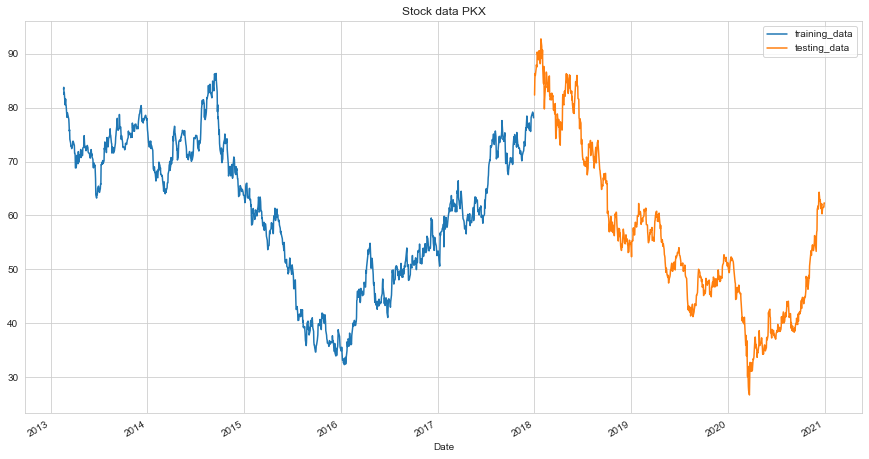

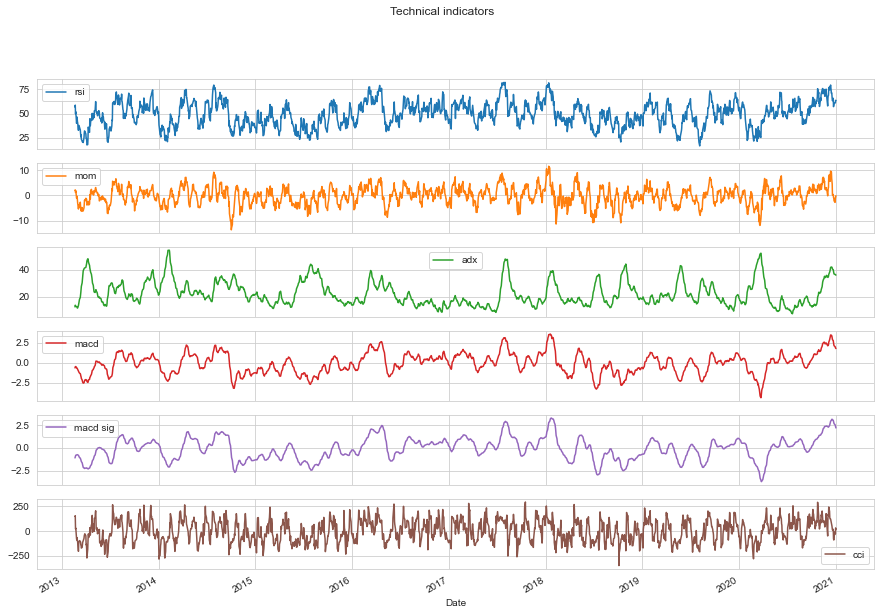

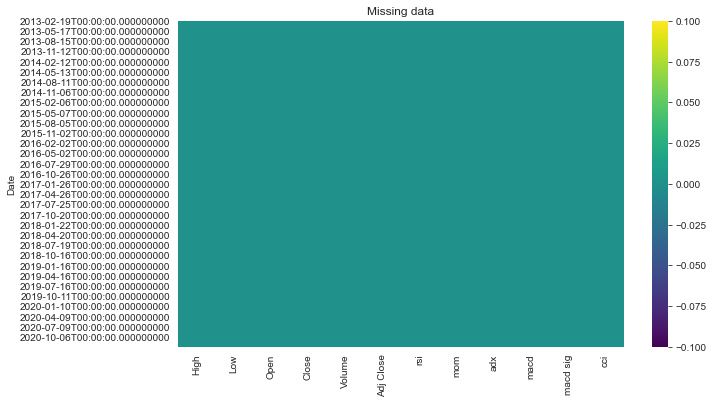

,High,Low,Open,Close,Volume,Adj Close,rsi,mom,adx,macd,macd sig,cci
Date,,,,,,,,,,,,
2013-02-19,84.519997,83.339996,84.519997,83.440002,380700,83.440002,56.792566,2.070000,12.617108,-0.642520,-1.094180,148.741629
2013-02-20,85.769997,83.660004,85.739998,83.790001,628900,83.790001,58.736995,2.180000,13.850851,-0.510796,-0.977503,155.819924
2013-02-21,83.459999,82.040001,83.410004,82.489998,346300,82.489998,49.776695,1.189995,13.441376,-0.505477,-0.883098,21.726510
2013-02-22,83.389999,82.139999,82.949997,82.830002,282200,82.830002,51.845740,1.849998,13.061150,-0.468426,-0.800163,29.653504
2013-02-25,82.690002,80.510002,82.599998,80.540001,207900,80.540001,39.917756,-1.099998,12.811732,-0.616737,-0.763478,-80.371818


In [5]:
stock_name = 'pkx'.upper()
stock_data = web.DataReader(stock_name, 'yahoo', '2013-01-01', '2021-01-01')
stock_data['Volume'] = stock_data['Volume'].apply(lambda vol: np.NaN if vol == 0 else vol)
stock_data['Adj Close'] = stock_data['Close']
stock_data['rsi'] = talib.RSI(stock_data['Adj Close'])
stock_data['mom'] = talib.MOM(stock_data['Adj Close'])
stock_data['adx'] = talib.ADX(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data['macd'], stock_data['macd sig'], _ = talib.MACD(stock_data['Adj Close'])
stock_data['cci'] = talib.CCI(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data.dropna(axis=0, inplace=True)

train_data = stock_data.loc[:'2018-01-01']
test_data = stock_data.loc['2018-01-01':]


print(f'Stock name: {stock_name}')
print(f'Start: {stock_data.index[0]}, End: {stock_data.index[-1]}')
print(f'Training data: {len(train_data)} ')
print(f'Tsesting data: {len(test_data)} ')

sns.set_style('whitegrid')
train_data['Adj Close'].plot(label='training_data', figsize=(15,8));
test_data['Adj Close'].plot(label='testing_data');
plt.title('Stock data '+ stock_name)
plt.legend();
plt.show()

stock_data[['rsi', 'mom', 'adx', 'macd', 'macd sig', 'cci']].plot(subplots=True, figsize=(15,10), title='Technical indicators');
plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(stock_data.isnull(), cmap='viridis');
plt.title('Missing data');
plt.show()
high = stock_data['Adj Close'].max()

stock_data.head()

# Agent

In [6]:
     

class QAgent(object):
    
    
    def __init__(self, state_size, action_size, gamma=0.9, ticker=''):
        
        
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model_nn()
        self.gamma = gamma  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.ticker = ticker
        self.save_epsilon = []
    
    
    
    def seeding(self, seeds=101):
        return np.random.seed(seeds)
    
    
    
    def build_model_nn(self):
        
        class LinearModel:
            
            def __init__(self, input_dim, n_action):
                
                self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
                self.b = np.zeros(n_action)
                self.vW = 0
                self.vb = 0
                self.losses = []
                

            def forward(self, s):
                return s.dot(self.W) + self.b
            

            def sgd(self, s, Y, learning_rate=0.01, momentum=0.9):
                num_values = np.prod(Y.shape)

                Y_hat = self.forward(s)  # shape (1, 8)
                gW = 2 * s.T.dot(Y_hat - Y) / num_values  # vector shape (7, 8)
                gb = 2 * (Y_hat - Y).sum(axis=0) / num_values  # scalar

                self.vW = momentum * self.vW - learning_rate * gW  # vector shape (7, 8)
                self.vb = momentum * self.vb - learning_rate * gb  # scalar

                self.W += self.vW  # vector shape (7, 8)
                self.b += self.vb  # scalar

                mse = np.mean((Y_hat - Y) ** 2)
                self.losses.append(mse)
        
        
        self.seeding()
        model = LinearModel(self.state_size, self.action_size)
        
        return model
    

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.forward(state)
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.forward(next_state), axis=1)

        target_full = self.model.forward(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self.save_epsilon.append(self.epsilon)
        

    def load(self):
   
        npz = np.load(f'state_dict/{self.ticker}.npz')
        self.model.W = npz['W']
        self.model.b = npz['b']
        print('Loading complete!!')
        


    def save(self):
        
        np.savez(f'state_dict/{self.ticker}.npz', W=self.model.W, b=self.model.b)
        
        print('Save!!')

# Environment

In [7]:
# environment

class SingleStockEnv:
    
    def __init__(self, data, capital, trade_fee_bid_percent = 0.01, trade_fee_ask_percent = 0.005):
        
        self.trade_fee_bid_percent = trade_fee_bid_percent/100
        self.trade_fee_ask_percent = trade_fee_ask_percent/100
        
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.current_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 8 #[stock price, stock_owned, cash__in_hand, rsi, mom, adx, macd, macd_sig]
        self.save_position = []
        self.save_port_val = [] 
        self.save_cash = []
        self.stock_value = []
        self.action_space = [0,1]
        self.sell_buy = None
        self.save_stock_price = []
        self.rsi = None
        self.mom = None
        self.adx = None
        self.macd = None
        self.masc_sig = None
        self.save_reward = None
        self.cashflow = None
        self.save_cashflow = None
        self.history_cashflow = None
        
        self.slope = None
        self.c = None
        self.reset()
        
        
    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi
        vector[4] = self.mom
        vector[5] = self.adx
        vector[6] = self.macd
        vector[7] = self.masc_sig
        return vector
    
    
    def reset(self):
        self.current_step = 0
        self.stock_owned = 0
        self.stock_price = self.stock_price_history['Adj Close'][self.current_step]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital] 
        self.save_cash = [self.capital]
        self.stock_value = [0]
        self.cashflow = 0
        self.sell_buy = ['hold']
        self.save_stock_price = [self.stock_price]
        self.rsi = self.stock_price_history['rsi'][self.current_step]
        self.mom = self.stock_price_history['mom'][self.current_step]
        self.adx = self.stock_price_history['adx'][self.current_step]
        self.macd = self.stock_price_history['macd'][self.current_step]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_step]
        self.save_reward = [0]
        self.save_cashflow = 0
        self.history_cashflow = [0]
        return self.state_vector()
    
    
    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand

    
    def cal_position(self):
        mid_price =  high/ 2
        max_pos = self.capital / mid_price
        self.slope = max_pos/-high
        self.c = -self.slope * high
        
        
        
        return self.slope * self.stock_price + self.c, max_pos
            

        
    def trade(self, action):

        assert action in self.action_space
        
        action_vec = self.action_space[action]
        
        
        if action_vec == 1:
            
            position_sh, max_pos = self.cal_position()
            diff = position_sh - self.stock_owned
            
            if diff < 0:
                #sell
                self.stock_owned = position_sh
                self.cash_in_hand += ((abs(diff) * self.stock_price)* (1 - self.trade_fee_bid_percent))

                if self.stock_price > high:
                    # ถ้าราคาหุ้นหลุดโซน
                    self.cashflow = self.cash_in_hand + (self.stock_owned * self.stock_price) - (
                                                         .5 * (max_pos + self.stock_owned) * high)

                else:
                    self.cashflow = self.cash_in_hand + (self.stock_owned * self.stock_price) - (
                                .5 * (max_pos + self.stock_owned) * self.stock_price)


                self.cash_in_hand -= self.cashflow
                self.save_cashflow += self.cashflow
                self.sell_buy.append('sell')

                
            elif diff > 0:
                #buy
                self.cash_in_hand -= ((abs(diff) * self.stock_price) * (1 + self.trade_fee_ask_percent))
                self.stock_owned = position_sh
                self.cashflow = self.cash_in_hand + (self.stock_owned * self.stock_price) - (
                        .5 * (max_pos + self.stock_owned) * self.stock_price)
                self.cash_in_hand -= self.cashflow

                self.sell_buy.append('buy')
                self.save_cashflow += self.cashflow
                
            else:
                
                self.sell_buy.append('hold')
        
        else:
            self.sell_buy.append('hold')
                
                
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)
        
        
             
    def step(self, action):
        assert action in self.action_space
        
        prev_val = self.save_cashflow
        self.current_step += 1
        self.stock_price = self.stock_price_history['Adj Close'][self.current_step]
        self.rsi = self.stock_price_history['rsi'][self.current_step]
        self.mom = self.stock_price_history['mom'][self.current_step]
        self.adx = self.stock_price_history['adx'][self.current_step]
        self.macd = self.stock_price_history['macd'][self.current_step]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_step]
        self.trade(action)
        current_val = self.save_cashflow
        self.history_cashflow.append(self.save_cashflow)
        reward = current_val - prev_val
        self.save_reward.append(reward)
        done = self.current_step == self.n_step - 1
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                'current_val': self.save_reward,
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy': self.sell_buy,
                'cashflow': self.history_cashflow
               }
        
        
        return self.state_vector(), reward, done, info
    
    
    def get_scaler(self):
        '''
        สร้าง model scaler โดยให้ทดลองรันก่อน
        '''

        # เก็บค่า states ทั้งหมด
        states = []
        for i in range(self.n_step):
            # ใช้ action แบบสุ่ม
            action = np.random.choice(self.action_space)

            # รับค่า state, reward, done, info
            state, reward, done, info = self.step(action)
            

            # เก็บค่า state ใน states
            states.append(state)
            if done:
                break

        # สเกล state
        scaler = StandardScaler()

        scaler.fit(states)
        return scaler

    
    


# Config

In [8]:
num_episodes = 2000

capital = 1000
train_env = SingleStockEnv(data=train_data,
                           capital=capital)
state_size = train_env.state_dim
nb_action = 2
agent = QAgent(state_size,
               nb_action,
               gamma=0.9,
               ticker=stock_name)
scaler = train_env.get_scaler()


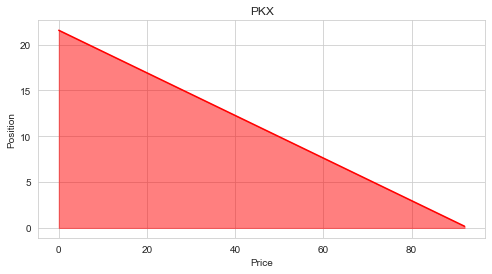

In [9]:
x = np.arange(high)
y = train_env.slope * x + train_env.c

plt.figure(figsize=(8,4))
plt.plot(x,y, 'r');
plt.fill_between(x, y, 0, alpha=0.5, color='r');
plt.xlabel('Price');
plt.ylabel('Position');
plt.title(stock_name);

# Training

Training Model


  0%|          | 0/2000 [00:00<?, ?it/s]

Episode:    1/2000
Begin portfolio value:  1000.00
End portfolio value:     975.12
Since: 1227 days
Return -2.49 %
Epsilon: 0.00999
Sell: 298, Buy: 277
Cumulative Reward:   119.55
Mean Squared Error Loss:   1.0639

Episode:  100/2000
Begin portfolio value:  1000.00
End portfolio value:     975.07
Since: 1227 days
Return -2.49 %
Epsilon: 0.00999
Sell: 132, Buy: 135
Cumulative Reward: 14418.33
Mean Squared Error Loss:   0.7616

Episode:  200/2000
Begin portfolio value:  1000.00
End portfolio value:     975.07
Since: 1227 days
Return -2.49 %
Epsilon: 0.00999
Sell: 187, Buy: 178
Cumulative Reward: 30377.75
Mean Squared Error Loss:   3.7216

Episode:  300/2000
Begin portfolio value:  1000.00
End portfolio value:     976.62
Since: 1227 days
Return -2.34 %
Epsilon: 0.00999
Sell: 78, Buy: 66
Cumulative Reward: 46616.01
Mean Squared Error Loss:   1.2418

Episode:  400/2000
Begin portfolio value:  1000.00
End portfolio value:     975.20
Since: 1227 days
Return -2.48 %
Epsilon: 0.00999
Sell: 103,

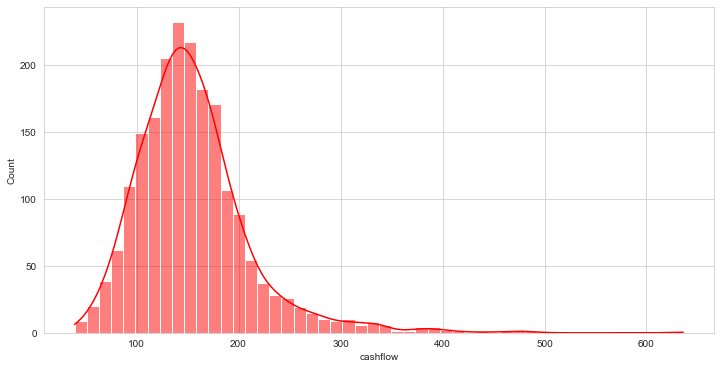

In [10]:
print('Training Model')
cashflow = []
total_reward = []

with open(f'scaler/{stock_name}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

for e in tqdm(range(num_episodes)):
    
    state = train_env.reset()
    state = scaler.transform([state])
    done = False
    step_reward = 0
    history_reward = []
    

    while not done:
        action = agent.act(state)
        next_state, last_reward, done, info = train_env.step(action)
        next_state = scaler.transform([next_state])
        agent.train(state, action, last_reward, next_state, done)
        step_reward += last_reward
        state = next_state
        history_reward.append(last_reward)
        
    total_reward.append(step_reward)
        
    
    if (e+1) % (num_episodes/20) == 0 or (e+1 == 1):     
        print(f"Episode: {e + 1:4}/{num_episodes}")
        print(f"Begin portfolio value: {capital:8.2f}")
        print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
        print(f'Since: {len(train_data)} days')
        print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
        print(f"Epsilon: {agent.epsilon:2.5f}")
        print(f"Sell: {train_env.sell_buy.count('sell')}, Buy: {train_env.sell_buy.count('buy')}")
        print(f'Cumulative Reward: {sum(total_reward):8.2f}')
        print(f"Mean Squared Error Loss: {agent.model.losses[-1]:8.4f}")
        print('=======================================================================')
        print()
    
    cashflow.append(info['cashflow'][-1]) 



agent.save()
losses = agent.model.losses

print(f'average reward: {np.mean(cashflow):.2f}, min: {np.min(cashflow):.2f}, max: {np.max(cashflow):.2f}')
plt.figure(figsize=(12,6))
sns.histplot(cashflow, bins=50, color='r', kde=True);
plt.xlabel('cashflow');
plt.ylabel('Count');


# Loss

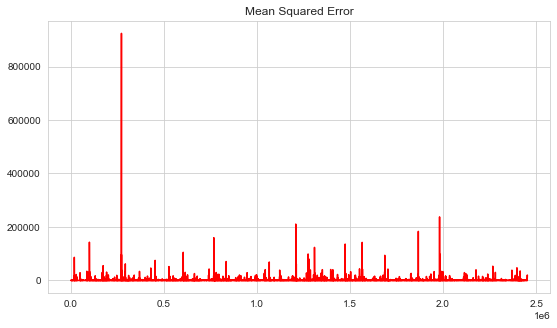

In [11]:
pd.Series(losses).plot(figsize=(9,5), c='r');
plt.title('Mean Squared Error');
plt.show()

# Reward

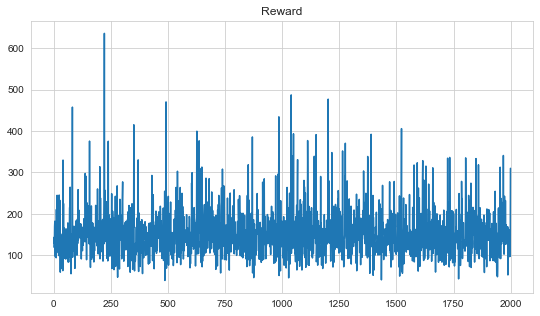

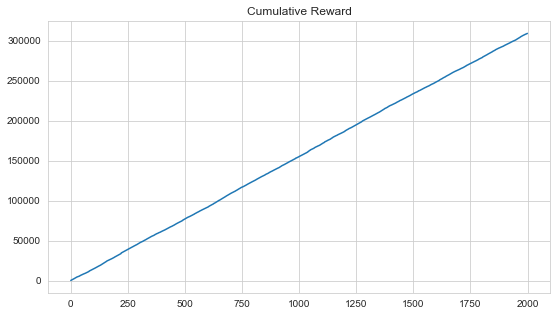

In [12]:
plt.figure(figsize=(9,5));
plt.plot(total_reward);
plt.title('Reward');
plt.show()
pd.Series(total_reward).cumsum().plot(figsize=(9,5));
plt.title('Cumulative Reward');

# Epsilon

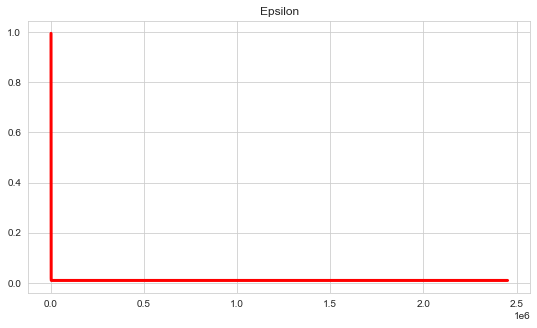

In [13]:
plt.figure(figsize=(9,5))
plt.plot(agent.save_epsilon, lw=3, c='r');plt.title('Epsilon');

# Validation

Loading complete!!
Testing Model



Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Since: 756 days
Begin portfolio value:  1000.00
End portfolio value:     975.07
Return -2.49 %
Sell: 273 times, Buy: 233 times


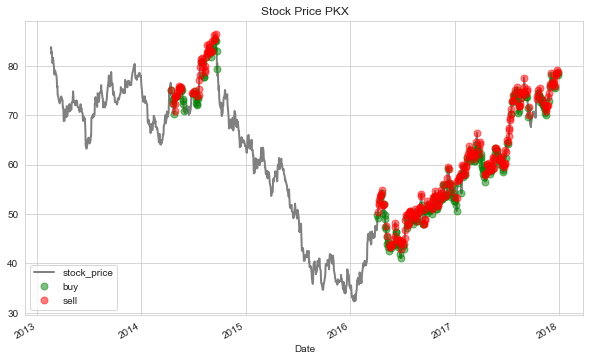

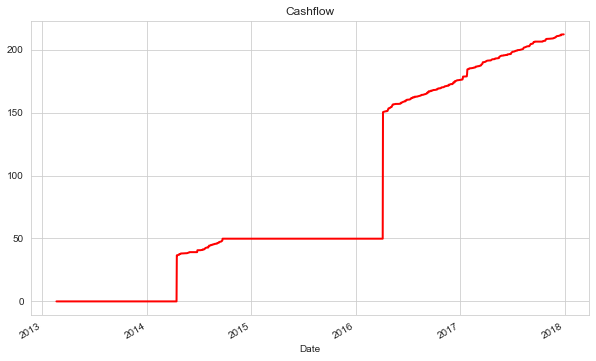

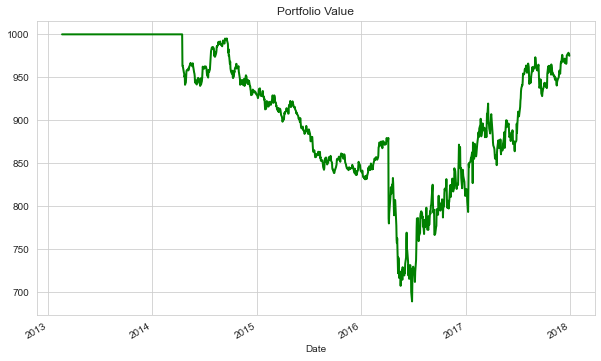

In [14]:
#validation 
capital = 1000
val_env = SingleStockEnv(train_data,
                             capital)
state_size = val_env.state_dim
nb_action = 2
agent = QAgent(state_size, nb_action, 0.9, ticker=stock_name)
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


state = val_env.reset()
state = scaler.transform([state])
last_reward = 0
done = False
agent.load()
agent.epsilon = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, info = val_env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {val_env.sell_buy.count('sell')} times, Buy: {val_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = train_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw='2');
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()


result['cashflow'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Cashflow');
plt.show()

result['portfolio_value'].plot(figsize=(10,6), c='g', lw=2);
plt.title('Portfolio Value');
plt.show()


# Testing

Loading complete!!
Testing Model



Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Since: 756 days
Begin portfolio value:  1000.00
End portfolio value:     892.15
Return -10.79 %
Sell: 236 times, Buy: 232 times


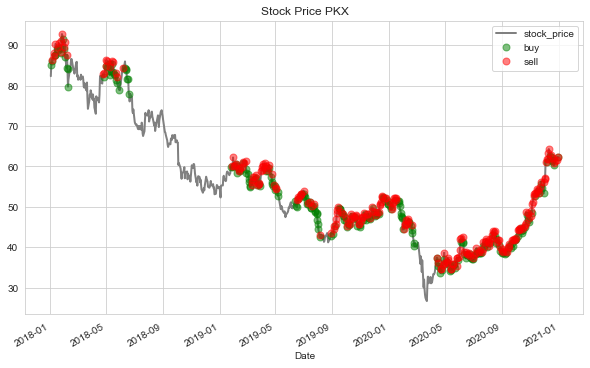

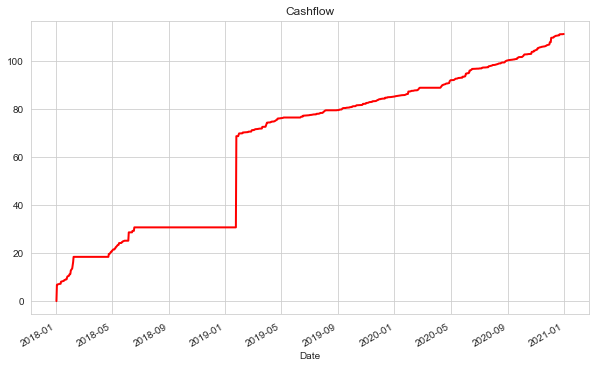

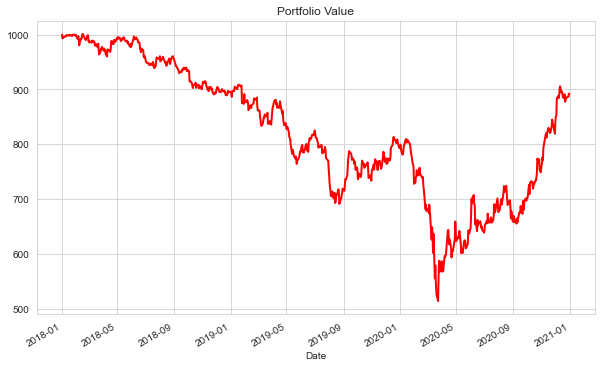

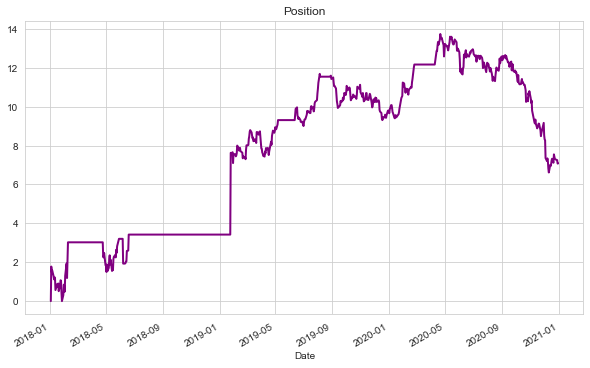

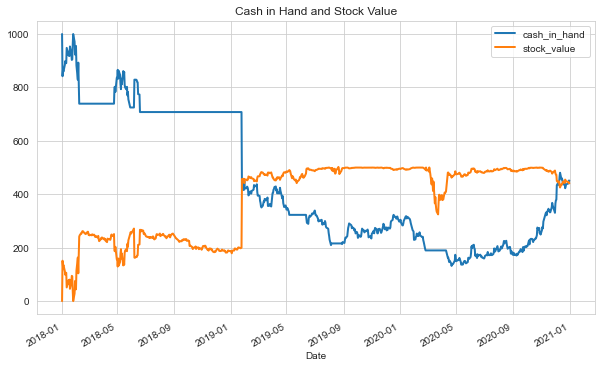

In [15]:
test_env = SingleStockEnv(test_data,
                             capital)
state_size = test_env.state_dim
nb_action = 2
agent = QAgent(state_size, nb_action, 0.9, ticker=stock_name)
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


state = test_env.reset()
state = scaler.transform([state])
last_reward = 0
done = False
agent.load()
agent.epsilon = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, info = test_env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {test_env.sell_buy.count('sell')} times, Buy: {test_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw=2);
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['cashflow'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Cashflow');
plt.show()

result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=2);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=2);
plt.title('Cash in Hand and Stock Value');
plt.show()

# Performance Measurement - KPIs

In [47]:
import numpy as np
import datetime as dt

bn = web.DataReader('^GSPC', 'yahoo', '2018-01-01', '2021-01-01')
bn['Benchmark'] = bn['Adj Close']

def CAGR(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    n = len(df)/252
    cagr = (df['cumulative_ret'][-1])**(1/n) - 1
    return cagr

def volatility(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    vol = df['daily_ret'].std() * np.sqrt(252)
    return vol


def sharpe(DF, rf):
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    df['cum_roll_max'] = df['cumulative_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cumulative_ret']
    df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd

def calmer(DF):
    df = DF.copy()
    clmr = CAGR(df)/max_dd(df)
    return clmr



print(f'Stock name: {stock_name}')
print(f'Start: {result.index[0]}  End: {result.index[-1]}')
print(f'Compound Annual Growth Rate: {CAGR(result)*100:.2f} %')
print(f'Volatility: {volatility(result):.4f}')
print(f'shape ratio: {sharpe(result, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(result)*-100:.2f} %')
print(f'Calmar ratio: {calmer(result):.4f}')
print('-----------------------------------------------------------')
print('Comparing with Benchmark')
print(f'Compound Annual Growth Rate (benchmark): {CAGR(bn)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(bn):.4f}')
print(f'shape ratio: {sharpe(bn, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(bn)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(bn):.4f}')
print('-----------------------------------------------------------')
print('Comparing with Adj close')
print(f'Compound Annual Growth Rate (Adj close): {CAGR(test_data)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(test_data):.4f}')
print(f'shape ratio: {sharpe(test_data, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(test_data)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(test_data):.4f}')


Stock name: BBL
Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Compound Annual Growth Rate: 8.69 %
Volatility: 0.1292
shape ratio: 0.5872
Maximun drawdown: -20.26 %
Calmar ratio: 0.4288
-----------------------------------------------------------
Comparing with Benchmark
Compound Annual Growth Rate (benchmark): 11.69 %
Volatility (benchmark): 0.2334
shape ratio: 0.4537
Maximun drawdown: -33.92 %
Calmar ratio (benchmark): 0.3446
-----------------------------------------------------------
Comparing with Adj close
Compound Annual Growth Rate (Adj close): 8.38 %
Volatility (benchmark): 0.3813
shape ratio: 0.1908
Maximun drawdown: -52.89 %
Calmar ratio (benchmark): 0.1584


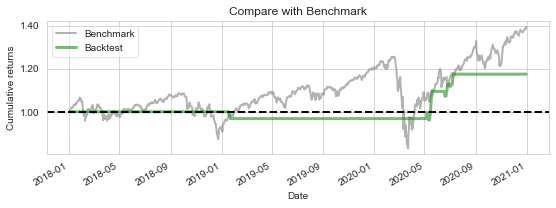

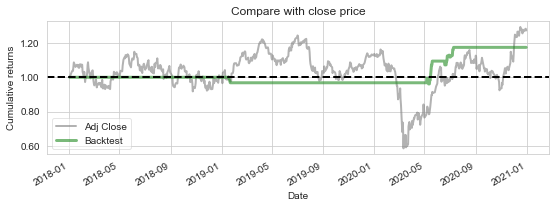

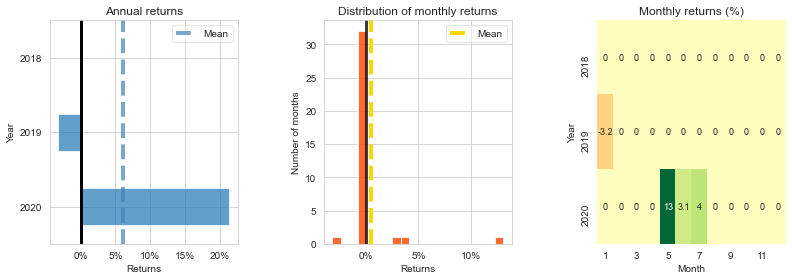

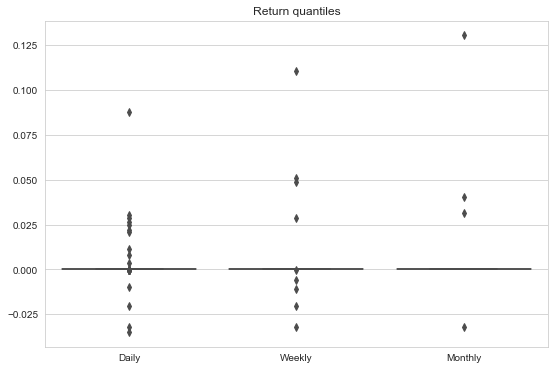

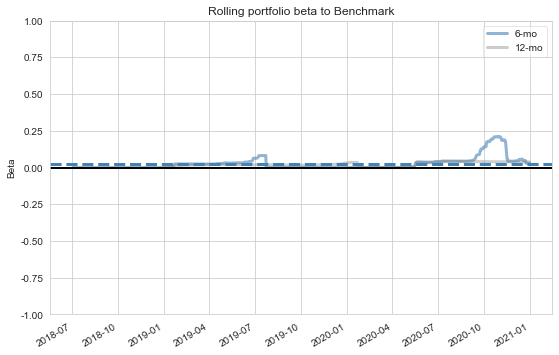

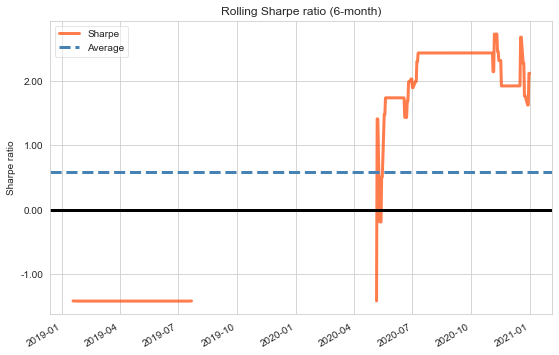

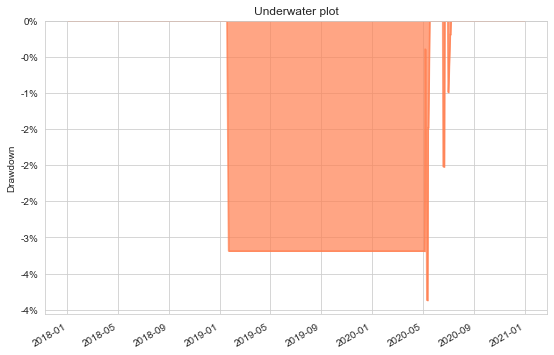

In [13]:
bt_returns = result['portfolio_value'].pct_change()
bm_returns = bn['Benchmark'].pct_change()
price = test_data['Adj Close'].pct_change()

plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, bm_returns);
plt.title('Compare with Benchmark');
plt.show()

plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_rolling_beta(bt_returns, bm_returns);

plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);